In [ ]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1viFv3uHGfNuq5olNqr80ekx9S42-9nNS',
  dest_path='./G_5_ant.npy')
  gdd.download_file_from_google_drive(file_id='1gumKga3nqan9WsBWcE_oxMSGc7nXXxtN',
  dest_path='./G_5_grapes.npy')
  gdd.download_file_from_google_drive(file_id='1a6ODxI7BxGkUH6qpRiyRa5bbOa-3hKE7',
  dest_path='./test_image.npy')
  gdd.download_file_from_google_drive(file_id='1yTInjFZl6VD71w7O6IZPxrX76xhR-8L9',
  dest_path='./test_label.npy')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the absolute path of your working directory with the data
Working_directory="./" 

In [ ]:
import numpy as np
import pandas as pd
from time import time

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
# this is needed to plot figures within the notebook
%matplotlib inline 
np.random.seed(seed=666)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# Read data

In [ ]:
# read data
ant = np.load('G_5_ant.npy')
grapes = np.load('G_5_grapes.npy')
X_test = np.load('test_image.npy')
y_test = np.load('test_label.npy')
print(ant.shape)
print(grapes.shape)
print(X_test.shape, y_test.shape)

(1000, 784)
(1000, 784)
(1000, 784) (1000,)


In [ ]:
print(ant[0])
print(grapes[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3  18   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  98 222 241  31   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3 236 255 249
 181   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   7  13 132 254   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 122 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 122 255   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0 122 255   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 122 255   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

The data are rather sparse

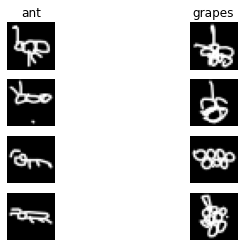

In [ ]:
# visualize some train data
num = 4

for i in range(num):
  plt.subplot(num, 2, 2*i+1)
  plt.imshow(ant[i].reshape(28,28), cmap='gray')
  plt.axis('off')
  if i == 0:
    plt.title('ant')
  plt.subplot(num, 2, (i+1)*2)
  plt.imshow(grapes[i].reshape(28,28), cmap='gray')
  plt.axis('off')
  if i == 0:
    plt.title('grapes')
plt.show()

**Comment:**

There are too many features, and too many nuisance variables. Therefore, it's necessary use some methods to reduce the dimensions later.

One of the difficulties is too select the most important features.

In [ ]:
# label 0 means ant, 1 means grapes

X = np.vstack((ant, grapes))
y = np.zeros(2000)
y[1000:] = 1


In [ ]:
# shuffle the data
indices = np.random.permutation(X.shape[0])
print(len(indices))
X_train = X[indices, :]
y_train = y[indices]
print(X_train.shape, y_train.shape)

2000
(2000, 784) (2000,)


# Preprocessing

## Scale data

First scale the data, because if we want to use some methods like PCA, it's necessary to center the data.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

## Feature selections

If we use some traditional ML methods, it's important to reduce the dimension by removing most nuisance variables. Otherwise, the execution time is too large and the performance won't be good.

### PCA

The simplest way is to apply PCA to select features

By doing some experience, we find we cannot choose a large number of components for PCA. If n_components is large, there may be too many nuisance variables, the performance of our model will decrease.

In [ ]:
pca = PCA(n_components=200,svd_solver='randomized', whiten=True)
pca.fit(X_train_scale)

X_train_pca = pca.transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)
print(np.sum(pca.explained_variance_ratio_))

0.881367534154416


### Random Forest

We can also use RF to select important features by using the feature_importance proporty.

Here we choose the 300 features whose feature_importance are large.

In [ ]:
n_component = 300

model = RandomForestClassifier(n_jobs=8, random_state=0)
model.fit(X_train_scale, y_train.ravel())

feature_importance = model.feature_importances_
index = np.argsort(feature_importance)[-1:-n_component-1:-1]

X_train_RF = X_train_scale[:, index]
X_test_RF = X_test_scale[:, index]

print(np.sum(feature_importance[index]))

0.816801155670825


# Classifier

## SVM

SVM is a rather simple but useful classifier, so we try SVM first.

I use RandomizedSearchCV, because it's faster than GridSearchCV

In [ ]:
p_grid_lsvm = {'C': [1e-3,1e-2,0.05,1e-1,0.5,1,2,5,1e1,1e2,15,20,40,60,80,120,140],
                'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1,2,4,8,10,15,20,30,40,50,60], }
Lsvm = SVC(kernel='rbf')
grid_lsvm = RandomizedSearchCV(estimator=Lsvm, param_distributions=p_grid_lsvm, scoring='f1', cv=5, n_jobs=8)


Here, we want to try the PCA preprocessed data and RF preprocessed data to compare the performance.

### PCA preprocessed data

In [ ]:
grid_lsvm.fit(X_train_pca, y_train.ravel())
test_score = grid_lsvm.score(X_test_pca, y_test.ravel())

print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
print("Test score: {}".format(test_score))

Best training Score: 0.8532808889985759
Best training params: {'gamma': 0.005, 'C': 10.0}
Test score: 0.8275862068965517


### RF preprocessed data

In [ ]:
grid_lsvm.fit(X_train_RF, y_train.ravel())
test_score = grid_lsvm.score(X_test_RF, y_test.ravel())

print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
print("Test score: {}".format(test_score))

Best training Score: 0.8908932499278963
Best training params: {'gamma': 0.005, 'C': 80}
Test score: 0.8642714570858283


Comparing the 2 results, we can find that the SVM can have a very good result on this dataset, and the RF preprocessed data can have larger train and test scores. 

## Boost

In [ ]:
XGB = XGBClassifier()
p_grid_xgb = dict(
    max_depth = [4, 5, 6, 7],
    learning_rate = np.linspace(0.03, 0.3, 10),
    n_estimators = [100, 200]
)

grid_xgb = RandomizedSearchCV(estimator=XGB, param_distributions=p_grid_xgb, scoring='f1', cv=5, n_jobs = 8)

### PCA preprocessed data

In [ ]:
grid_xgb.fit(X_train_pca, y_train.ravel())
test_score = grid_xgb.score(X_test_pca, y_test.ravel())

print("Best training Score: {}".format(grid_xgb.best_score_))
print("Best training params: {}".format(grid_xgb.best_params_))
print("Test score: {}".format(test_score))

Best training Score: 0.8786026537458913
Best training params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.21000000000000002}
Test score: 0.850597609561753


### RF preprocessed data

In [ ]:
grid_xgb.fit(X_train_RF, y_train.ravel())
test_score = grid_xgb.score(X_test_RF, y_test.ravel())

print("Best training Score: {}".format(grid_xgb.best_score_))
print("Best training params: {}".format(grid_xgb.best_params_))
print("Test score: {}".format(test_score))

Best training Score: 0.8879293681811647
Best training params: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.12000000000000001}
Test score: 0.8519637462235649


I find on the Internet that the boosting method will generally better than SVM. But here, the result of boosting methode is even slightly lower than SVM. Maybe it's because I have choose a good candidate hyperparameter list for boosting, while I choose a large candidate list for SVM.

## MLP from sklearn

In our course, we use tensorflow to implement MLP, but I also find that sklearn has a MLPClassifier, so I just want to have a try.

In [ ]:
MLP = MLPClassifier(activation='relu', alpha=1e-4, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(256,256,128), 
       learning_rate_init=0.01, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       tol=0.0001, validation_fraction=0.1,
       warm_start=False, verbose=10)

p_grid_mlp = {'solver': ['adam', 'sgd'], 'learning_rate' : ['adaptive', 'constant']}
grid_mlp = RandomizedSearchCV(estimator=MLP, param_distributions=p_grid_mlp, scoring='f1', cv=5, n_jobs = 8)

### Original dimension

In [ ]:
grid_mlp.fit(X_train_scale, y_train.ravel())
test_score = grid_mlp.score(X_test_scale, y_test.ravel())

print("Best training Score: {}".format(grid_mlp.best_score_))
print("Best training params: {}".format(grid_mlp.best_params_))
print("Test score: {}".format(test_score))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Iteration 1, loss = 0.63299174
Iteration 2, loss = 0.39612204
Iteration 3, loss = 0.32608897
Iteration 4, loss = 0.28507113
Iteration 5, loss = 0.25161340
Iteration 6, loss = 0.22692375
Iteration 7, loss = 0.20223415
Iteration 8, loss = 0.17961521
Iteration 9, loss = 0.15810022
Iteration 10, loss = 0.13930143
Iteration 11, loss = 0.12122790
Iteration 12, loss = 0.10547915
Iteration 13, loss = 0.08988902
Iteration 14, loss = 0.07705874
Iteration 15, loss = 0.06559039
Iteration 16, loss = 0.05511256
Iteration 17, loss = 0.04712672
Iteration 18, loss = 0.03945287
Iteration 19, loss = 0.03312853
Iteration 20, loss = 0.02789043
Iteration 21, loss = 0.02379175
Iteration 22, loss = 0.02017064
Iteration 23, loss = 0.01710608
Iteration 24, loss = 0.01478470
Iteration 25, loss = 0.01272773
Iteration 26, loss = 0.01110543
Iteration 27, loss = 0.00972781
Iteration 28, loss = 0.00857734
Iteration 29, loss = 0.00769563
Iteration 30, loss = 0.00685997
Iteration 31, loss = 0.00618679
Iteration 32, los

### PCA preprocessed data

In [ ]:
grid_mlp.fit(X_train_pca, y_train.ravel())
test_score = grid_mlp.score(X_test_pca, y_test.ravel())

print("Best training Score: {}".format(grid_mlp.best_score_))
print("Best training params: {}".format(grid_mlp.best_params_))
print("Test score: {}".format(test_score))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Iteration 1, loss = 0.89814494
Iteration 2, loss = 0.30825331
Iteration 3, loss = 0.18784133
Iteration 4, loss = 0.08140631
Iteration 5, loss = 0.02977282
Iteration 6, loss = 0.01633751
Iteration 7, loss = 0.01709274
Iteration 8, loss = 0.02511490
Iteration 9, loss = 0.03686444
Iteration 10, loss = 0.05250993
Iteration 11, loss = 0.02693690
Iteration 12, loss = 0.01859762
Iteration 13, loss = 0.01003171
Iteration 14, loss = 0.00684278
Iteration 15, loss = 0.00831493
Iteration 16, loss = 0.00493901
Iteration 17, loss = 0.00717676
Iteration 18, loss = 0.01940204
Iteration 19, loss = 0.02295096
Iteration 20, loss = 0.06523056
Iteration 21, loss = 0.04835995
Iteration 22, loss = 0.01980844
Iteration 23, loss = 0.00842801
Iteration 24, loss = 0.00442902
Iteration 25, loss = 0.00641902
Iteration 26, loss = 0.00194156
Iteration 27, loss = 0.00103644
Iteration 28, loss = 0.00060118
Iteration 29, loss = 0.00052571
Iteration 30, loss = 0.00049259
Iteration 31, loss = 0.00047749
Iteration 32, los

### RF preprocessed data

In [ ]:
grid_mlp.fit(X_train_RF, y_train.ravel())
test_score = grid_mlp.score(X_test_RF, y_test.ravel())

print("Best training Score: {}".format(grid_mlp.best_score_))
print("Best training params: {}".format(grid_mlp.best_params_))
print("Test score: {}".format(test_score))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Iteration 1, loss = 1.03740029
Iteration 2, loss = 0.29554113
Iteration 3, loss = 0.25376441
Iteration 4, loss = 0.21105941
Iteration 5, loss = 0.17371613
Iteration 6, loss = 0.13824737
Iteration 7, loss = 0.10085602
Iteration 8, loss = 0.04891018
Iteration 9, loss = 0.03979319
Iteration 10, loss = 0.04057065
Iteration 11, loss = 0.03821473
Iteration 12, loss = 0.04321920
Iteration 13, loss = 0.02603392
Iteration 14, loss = 0.01904863
Iteration 15, loss = 0.01206219
Iteration 16, loss = 0.00912584
Iteration 17, loss = 0.00521939
Iteration 18, loss = 0.00369708
Iteration 19, loss = 0.00224399
Iteration 20, loss = 0.00089506
Iteration 21, loss = 0.00194352
Iteration 22, loss = 0.01870870
Iteration 23, loss = 0.01790862
Iteration 24, loss = 0.02428901
Iteration 25, loss = 0.01426579
Iteration 26, loss = 0.01538837
Iteration 27, loss = 0.02072495
Iteration 28, loss = 0.01946963
Iteration 29, loss = 0.02087605
Iteration 30, loss = 0.01392759
Iteration 31, loss = 0.01083154
Training loss did

### Comments

From this 3 results, we can find that:

1. For the methods like MLP, if we have a deep network, we can directly use the original data as input, and the result is as good as the result of RF preprocessed data.

2. Maybe I haven't selected a good hyperparameter, the best performance of MLP is even lower to SVM

## MLP from tensorflow

Code is modified from the TP of our image course

In [ ]:
import tensorflow as tf

# import tensorflow models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
print(tf.keras.__version__)

2.4.0


In [ ]:
# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_hidden_3 = 128 # 2nd layer number of neurons

n_input = X_train.shape[1]

# TO CODE BY STUDENTS


model_mlp_multi_layer = Sequential()   # FILL IN STUDENTS
model_mlp_multi_layer.add(Dense(n_hidden_1, input_shape=(n_input,)))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Activation('relu'))
model_mlp_multi_layer.add(Dense(n_hidden_2))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Activation('relu'))
model_mlp_multi_layer.add(Dense(n_hidden_3))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Activation('relu'))
model_mlp_multi_layer.add(Dense(1, activation='sigmoid'))

# create the loss and optimiser, use 'binary_crossentropy' in loss
learning_rate = 0.01
model_mlp_multi_layer.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(lr=learning_rate),metrics=["accuracy"])

# Run optimisation algorithm
n_epochs = 50
batch_size = 64

print('Training')
model_mlp_multi_layer.fit(X_train_scale, y_train, epochs=n_epochs,batch_size=batch_size) # TO FILL IN

print('Testing')
y_pre = model_mlp_multi_layer.predict(X_test_scale) # TO FILL IN
print(y_pre.shape)
y_pre = np.around(y_pre)

print(f1_score(y_test, y_pre.reshape(-1)))

Training
Epoch 1/50
32/32 [==============================] - 4s 4ms/step - loss: 0.4543 - accuracy: 0.7882
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 0.2207 - accuracy: 0.9186
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 0.1587 - accuracy: 0.9399
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.1294 - accuracy: 0.9545
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0636 - accuracy: 0.9748
Epoch 6/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.9719
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0544 - accuracy: 0.9825
Epoch 8/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0810 - accuracy: 0.9681
Epoch 9/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0442 - accuracy: 0.9875
Epoch 10/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0380 - accuracy: 0.9840
Epoch 11/5

It seems that the best performance of MLP is even lower than the best performance of SVM.

This is strange, because I thought the MLP method will generally be better than SVM. Maybe it's still because of the hyperparameters.

## CNN

This dataset is a set of pictures, so it's possible we use a simple CNN to extract the features just like MNIST.

The code is modified from our image class project

In [ ]:
import numpy as np
from PIL import Image
from torch.utils import data
import sys
import cv2
import random
import torchvision.transforms as transforms
import torch
import pandas as pd
import torchvision.models as models
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

### preprocessing

In [ ]:
X_train = X_train.reshape((-1, 28, 28))
X_test = X_test.reshape((-1, 28, 28))

X_train = np.array(X_train, dtype='uint8')
X_test = np.array(X_test, dtype='uint8')

In [ ]:
# data augmentation
def random_horizontal_flip(imgs):
    if random.random() < 0.5:
        imgs = np.flip(imgs, axis=1).copy()
    return imgs

def random_rotate(imgs):
    max_angle = 20
    angle = random.random() * 2 * max_angle - max_angle
    
    w, h = imgs.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((h / 2, w / 2), angle, 1)
    img_rotation = cv2.warpAffine(imgs, rotation_matrix, (h, w))
    imgs = img_rotation
    return imgs

In [ ]:
class trainset(data.Dataset):
    def __init__(self, train_data, train_label):
        self.train_data = train_data
        self.train_label = train_label
    def __getitem__(self, index):
        img = self.train_data[index]
        img = random_horizontal_flip(img)
        img = random_rotate(img)
        img = torch.from_numpy(img)
        img = img.unsqueeze(0)
        img = transforms.ToPILImage()(img)
        img = transforms.ToTensor()(img)
        img = transforms.Normalize((0.1307,), (0.3081,))(img)
        target = self.train_label[index]
        target = torch.tensor(target).long()
        return img,target

    def __len__(self):
        return self.train_data.shape[0]

class testset(data.Dataset):
    def __init__(self, test_data):
        self.test_data = test_data
    def __getitem__(self, index):
        img = self.test_data[index]
        img = torch.from_numpy(img)
        img = img.unsqueeze(0)
        img = transforms.ToPILImage()(img)
        img = transforms.ToTensor()(img)
        img = transforms.Normalize((0.1307,), (0.3081,))(img)
        return img

    def __len__(self):
        return self.test_data.shape[0]

In [ ]:
Trainset = trainset(X_train, y_train)
Testset = testset(X_test)

In [ ]:
train_loader = torch.utils.data.DataLoader(
        Trainset,
        batch_size=64,
        shuffle=True,
        num_workers=2,
        drop_last=False,
        pin_memory=True)
test_loader = torch.utils.data.DataLoader(
        Testset,
        batch_size=1,
        shuffle=False,
        num_workers=2,
        drop_last=True)

### Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(12544, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        # print(x.shape)
        x = self.conv3(x)
        x = F.relu(x)
        # print(x.shape)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # output = F.log_softmax(x, dim=1)
        return x

### Train

In [ ]:
model = Net().cuda()

criterion = nn.CrossEntropyLoss().cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

max_epoch = 25

train_loss = []

In [ ]:
for epoch in range(max_epoch):
  model.train()
  epoch_loss = 0
  for batch_idx, (imgs, gt) in enumerate(train_loader):

        imgs = Variable(imgs.cuda())
        gt = Variable(gt.cuda())

        
        outputs = model(imgs)

        loss = criterion(outputs, gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if batch_idx % 10 == 0:
          print("Epoch "+str(epoch)+": "+str(batch_idx) + " loss: " + str(loss.item()))
  train_loss.append(epoch_loss/(batch_idx+1))
  scheduler.step()

Epoch 0: 0 loss: 0.6994697451591492
Epoch 0: 10 loss: 0.47836965322494507
Epoch 0: 20 loss: 0.3933480978012085
Epoch 0: 30 loss: 0.34025445580482483
Epoch 1: 0 loss: 0.18642288446426392
Epoch 1: 10 loss: 0.22465880215168
Epoch 1: 20 loss: 0.18164950609207153
Epoch 1: 30 loss: 0.31143060326576233
Epoch 2: 0 loss: 0.2045906037092209
Epoch 2: 10 loss: 0.21520139276981354
Epoch 2: 20 loss: 0.2564404010772705
Epoch 2: 30 loss: 0.28965261578559875
Epoch 3: 0 loss: 0.19591739773750305
Epoch 3: 10 loss: 0.18788085877895355
Epoch 3: 20 loss: 0.18301177024841309
Epoch 3: 30 loss: 0.09504547715187073
Epoch 4: 0 loss: 0.29785266518592834
Epoch 4: 10 loss: 0.1789146065711975
Epoch 4: 20 loss: 0.07107450813055038
Epoch 4: 30 loss: 0.1857064962387085
Epoch 5: 0 loss: 0.14215466380119324
Epoch 5: 10 loss: 0.1428649127483368
Epoch 5: 20 loss: 0.14243733882904053
Epoch 5: 30 loss: 0.16629721224308014
Epoch 6: 0 loss: 0.11643721908330917
Epoch 6: 10 loss: 0.10955256223678589
Epoch 6: 20 loss: 0.124720141

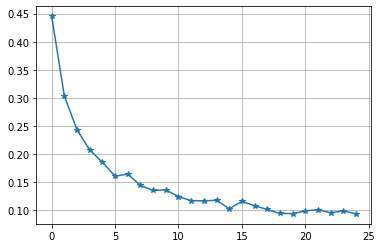

In [ ]:
plt.plot(train_loss, marker='*')
plt.grid()

### Test

In [ ]:
model = model.cuda()

model.eval()

y_pred = []

for idx, img in enumerate(test_loader):
  with torch.no_grad():
    img = Variable(img.cuda())
    
    torch.cuda.synchronize()

    outputs = model(img)

    outputs = outputs.squeeze(0).cpu().detach().numpy().astype(np.float32)

    result = np.argmax(outputs)

    y_pred.append(result)
    torch.cuda.synchronize()


In [ ]:
f1_score(y_test, y_pred)

0.9243353783231084

The result is much than the other methods just as I expected.

This is because CNN can better extract the features from images. CNN can preserve the position information, which is very important for images.

# Conclusion

The CNN method can obtain a f1 score 0.9243353783231084, which is much higher than the other methods.

It seems the CNN based deep learning is the best model for computer vision (maybe now transformer is better, I'm not sure)